Ordinary differential equations: Conversion reaction
====================================================

<div class="alert alert-warning">
Note: Before you use pyABC to parametrize your ODE, please be aware of potential errors introduced by inadequately representing the data generation process, see also the "Measurement noise assessment" notebook. For deterministic models, there are often more efficient alternatives to ABC, check out for example our tool <a href="https://github.com/ICB-DCM/pyPESTO">pyPESTO</a>.
</div>

We try to piece-wise fit the following concentration ODE, which assumes homogeneous mixing.


$$
   \dfrac{dC}{dt} = \dfrac{E}{V}-\lambda C
$$

Which has a general solution:

$$
C(t)=\dfrac{E}{V\lambda}(1-e^{-\lambda t})+ k e^{-\lambda t}
$$

Where $k$ is the integration constant

Measurement of $[C]$ is provided as $Y = [C]$.

We need to estimate $E$, $k$ and $\lambda$

In [1]:
# install if not done yet
#!pip install pyabc --quiet

In [55]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

Data
----

We use an artificial data set which consists of a vector of time points $t$
and a measurement vector $Y$. This data was created using the parameter 
values which are assigned to $\Theta_{\text{true}}$ and by adding normaly distributed 
measurement noise with variance $\sigma^2 = 0.015^2$. 


and the measurement data

In [210]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv('../data/vmn_mp_conc.txt', sep='\t',header=0)
data["time"] = data["time"].apply(lambda x: datetime.strptime(x, "%M:%S"))
data["fraction_of_hour"] = data["time"].apply(lambda x: (x.minute+x.second/60) / 60)
measurement_data = data['conc_2'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['conc_2']])

as well as the time points at whith to evaluate

In [251]:
measurement_times = data['fraction_of_hour']#np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['fraction_of_hour']])

(135,)

and the initial conditions for $C$

In [211]:
init = np.array([0])

Define the ODE model

In [300]:
def conc_function(t,E,V,k, lambda_):
    res = k*np.exp(-lambda_*t) + (E/V)*(1-np.exp(-lambda_*t))/lambda_ 
    return  res

def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    #mp type
    t0 = measurement_times[0:15] # no emission between 0 and 5 minutes
    t1 = measurement_times[15:44] # emission between 5 and 14 minutes
    t2 = measurement_times[55:135]# no emission between 14 and 45 minutes
    C0 = data['conc_2'][0:15].mean() # find the mean of the first 15 data points
    C0 = np.repeat(C0,len(t0))
    V = 36.247
    C1 = conc_function(t1-np.min(t1),parameters['E'],V,parameters['k'],parameters['lambda_']).flatten() # this is the mp experiment
    C2 = conc_function(t2,0,V,parameters["k"],parameters['lambda_']).flatten() # this is the mp experiment
    
    C = np.concatenate((C0,C1,C2))
    return{"Concentration":C}

def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : tuple
        Tuple containing the values of the parameters k and lambda.
    t : array-like
        Array of time values.
        
    Returns
    -------
    C : array-like
        Array of concentration values at the given times.
    """
    E = param['E']
    k = param['k']
    lambda_ = param['lambda_']

    #E, k, lambda_ = param
    t = measurement_times
    # Initialize empty array for concentration values
    C = np.zeros_like(t)
    V = 36.247
    # Loop over time values
    for i, ti in enumerate(t):
        # If time is less than 5 minutes, set concentration to k
        if ti < 5/60:
            C[i] = 0.003851195
        # If time is between 5 and 20 minutes, set concentration according to ODE solution
        elif 5/60 <= ti < 14/60:
            C[i] =  (E/V)*(1-np.exp(-lambda_*(ti-5/60)))/lambda_ #k*np.exp(-lambda_*(ti-5/60)) +
        # If time is greater than 20 minutes, set concentration to 0
        else:
            C[i] = k*np.exp(-lambda_*(ti-14/60)) 
    # Add noise to the simulated data
    sigma = 0.001
    C += np.random.normal(0, sigma, size=C.shape)

    return {"Concentration":C}

model({"E":0.0001,"k":0.003851195,"lambda_":0.0001})['Concentration'].shape

distance({"Concentration":measurement_data}, model({"E":10,"k":0.003851195,"lambda_":1.11}))


1.8683493684880321

Define the true parameters

In [301]:
E_true, k_true, lambda_true = np.exp([3.38, 0.003, 1.174])
#t1 = measurement_times[15:44]
#t1-np.min(t1)
#model({"E": E_true, "k": k_true, "lambda_":lambda_true})

Solve the model for the true parameter values

Let's visualize the results

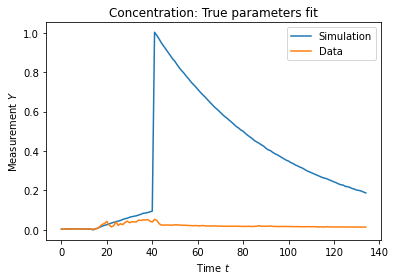

In [302]:
param = {"E": E_true, "k": k_true, "lambda_":lambda_true}
true_trajectory = model(param)["Concentration"]
import matplotlib.pyplot as plt
plt.plot(true_trajectory, color="C0", label='Simulation')
plt.plot(measurement_data, color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Concentration: True parameters fit')
plt.legend()
plt.show()

In [303]:
def distance(simulation, data):
    return np.absolute(data["Concentration"] - simulation["Concentration"]).sum()

Define the prior for $\Theta_1$ and $\Theta_2$

In [304]:
parameter_prior = Distribution(
    E=RV("uniform", 0, 10), k=RV("uniform", 0, 5), lambda_=RV("uniform", 0, 5)
)
parameter_prior.get_parameter_names()

['E', 'k', 'lambda_']

In [305]:
abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=50,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(1000, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [306]:
abc.new(db_path, {"Concentration": measurement_data});

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyabc/storage/dataframe_bytes_storage.py:128: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  warnings.warn(
ABC.History INFO: Start <ABCSMC id=50, start_time=2022-12-21 21:28:21>


In [307]:
h = abc.run(minimum_epsilon=1, max_nr_populations=5)

ABC INFO: t: 0, eps: 1.00000000e+03.
ABC INFO: Accepted: 50 / 50 = 1.0000e+00, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 8.74498515e+01.
ABC INFO: Accepted: 50 / 169 = 2.9586e-01, ESS: 2.8818e+01.
ABC INFO: t: 2, eps: 3.16526102e+01.
ABC INFO: Accepted: 50 / 157 = 3.1847e-01, ESS: 4.1209e+01.
ABC INFO: t: 3, eps: 1.05183819e+01.
ABC INFO: Accepted: 50 / 157 = 3.1847e-01, ESS: 3.2144e+01.
ABC INFO: t: 4, eps: 3.54114359e+00.
ABC INFO: Accepted: 50 / 135 = 3.7037e-01, ESS: 3.6276e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=50, duration=0:00:28.338639, end_time=2022-12-21 21:28:49>


Visualization of the probability density functions for $E$, $k$ and $\lambda$

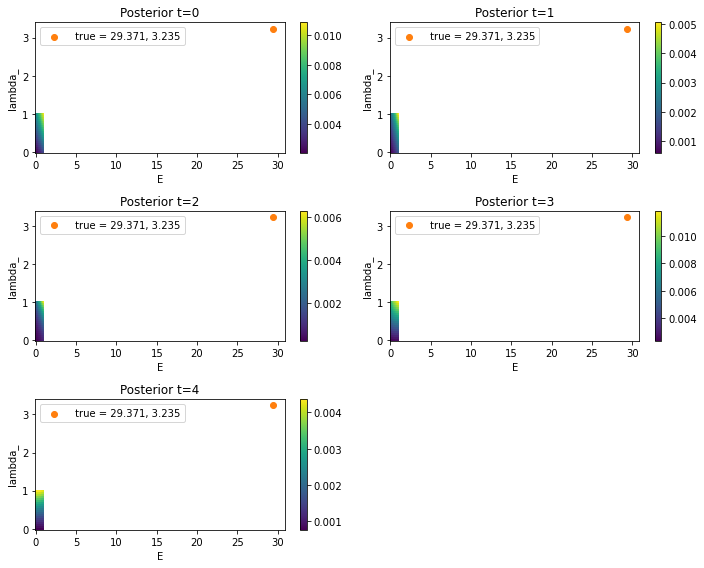

In [308]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "E",
        "lambda_",
        xmin=0,
        xmax=1,
        numx=20,
        ymin=0,
        ymax=1,
        numy=20,
        ax=ax,
    )
    ax.scatter(
        [E_true],
        [lambda_true],
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            E_true, lambda_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

We can also plot the simulated trajectories:

In [311]:
# print the best parameter set



AttributeError: 'History' object has no attribute 'get_best_parameters'